In [1]:
# all modules necessary for this nb
import os
import sys
import pickle

import numpy as np
np.random.seed(0)
import pylab as pl
import scipy.stats as sstats

# setting parameters for default matplotlib plots
%matplotlib inline

In [2]:
pl.style.use('fabiostyle')
# needs to find the library of functions
sys.path.append('../../code/')  # to be replaced!

import utils as ut
import plots as pt

In [3]:
NOTEBOOK_NAME = 'decoding_four_odors_combined_ALL_05sec'

In [4]:
from pickleshare import PickleShareDB

autorestore_folder = os.path.join(os.getcwd(), 'autorestore', NOTEBOOK_NAME)
db = PickleShareDB(autorestore_folder)
import sys
from workspace import *
import IPython
ip = IPython.get_ipython()

# this will restore all the saved variables. ignore the errors listed.
#load_workspace(ip, db)

# use `save_worspace(db)` to save variables at the end

In [5]:
from sklearn.model_selection import cross_val_score, cross_val_predict, LeaveOneOut
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC
import numpy as np
cv = LeaveOneOut()

decoder = LinearSVC()

In [6]:
import h5py

#def load_decoding_data(animals, session, notebook, cellreg=False):
##     patterns = dict(zip(animals, [ut.load_variable('patterns_evs', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
##                                     for ani in animals]))
##     labels = dict(zip(animals, [ut.load_variable('labels', '../%s/%s/notebooks/autorestore/%s/'%(ani, session, notebook))
##                                         for ani in animals]))
#    
#    patterns = ut.load_all_animals_vars('patterns_evs', animals, session, notebook,)
#    labels = ut.load_all_animals_vars('labels', animals, session, notebook)
#    if cellreg:
#        cellregs = {}
#        for ani in animals:
#            try:
#                cellregs[ani] = load_cellreg(ani)
#            except IOError:
#                raise Exception("Cannot find cellreg data for %s."%ani)
#        for k, v in patterns.items():
#            patterns[k] = patterns[k][:, cellregs[k][session]]
#    else:
#        cellregs = None
#
#    return patterns, labels
#
#
def do_decoding_combined_within(patterns, labels, n_loops=10, ncells=None, cellreg=False, n_steps=15, **args):
     
    scores = np.r_[[do_test_within(patterns, labels, **args) for i in range(n_loops)]]
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_test_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, ncells, scores_ncells


from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.svm import SVC

def combine_train_test_patterns(patterns, labels, train_test_split=0.5, classes=None, n_cells=None,
                                relabel=None, relabel_test=None):
#     which_train = range(90)
#     which_test = range(90)

    if classes is None:
        classes = [0, 1]

    which_train = {}
    which_test = {}
    for ani in patterns.keys():
        which_trains = []
        which_tests = []
        for l in classes:
            if l>=0:
                wt = np.random.permutation(np.where(labels[ani]==l)[0])
                if train_test_split<1:
                    wT = wt[:int(len(wt)*train_test_split)]
                    which_trains.append(wt[int(len(wt)*train_test_split):])
                    which_tests.append(wT)
                else:
                    which_trains.append(wt)
        which_train[ani] = np.concatenate(which_trains)
        if train_test_split<1:
            which_test[ani] = np.concatenate(which_tests)
    
    patterns_t = patterns.copy()
    labels_t = labels.copy()
    for ani in patterns.keys():
        patterns_t[ani] = patterns[ani][which_train[ani]]
        labels_t[ani] = labels[ani][which_train[ani]]
    patterns_comb_train, labels_comb_ = ut.combine_patterns(patterns_t, labels_t, classes=classes)
        
    if train_test_split<1:
        patterns_T = patterns.copy()
        labels_T = labels.copy()
        for ani in patterns.keys():
            patterns_T[ani] = patterns[ani][which_test[ani]]
            labels_T[ani] = labels[ani][which_test[ani]]
        patterns_comb_test, labels_comb_test_ = ut.combine_patterns(patterns_T, labels_T, classes=classes)
    else:
        patterns_comb_test = None
    
    if relabel is not None:
        labels_comb = np.r_[[relabel[l] for l in labels_comb_]]
    else:
        labels_comb = labels_comb_
    
    if relabel_test is not None:
        labels_comb_test = np.r_[[relabel_test[l] for l in labels_comb_test_]]
    else:
        if relabel is not None:
            labels_comb_test = np.r_[[relabel[l] for l in labels_comb_test_]]
        else:
            labels_comb_test = labels_comb_test_
    
    
    if n_cells is None:
        which_cells = [True]*patterns_comb_train.shape[1]
    else:
        which_cells = np.random.permutation(range(patterns_comb_train.shape[1]))[:n_cells]
     
    patterns_comb_train = patterns_comb_train[:, which_cells]
    patterns_comb_test = patterns_comb_test[:, which_cells] if train_test_split<1 else patterns_comb_test

    return (patterns_comb_train[labels_comb>=0], labels_comb[labels_comb>=0],
            patterns_comb_test[labels_comb_test>=0], labels_comb_test[labels_comb_test>=0])
        
def do_test_within(patterns, labels, **args):
    x, y, xT, yT = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.score(xT, yT)

def do_test_across(patterns_train, labels_train, patterns_test, labels_test, **args):
    x, y, _, _ = combine_train_test_patterns(patterns_train, labels_train, train_test_split=1, **args)
    xT, yT, _, _ = combine_train_test_patterns(patterns_test, labels_test, train_test_split=1, **args)
    decoder.fit(x, t)
    return decoder.score(xT, yT)

In [7]:
#for confusion matrix (use predict instead of score)
def do_prediction_combined_within(animals, patterns, labels, ncells=None, cellreg=False, n_steps=15, **args):
    
    scores, test_labels = do_predict_within(patterns, labels, **args) #had to remove n_loops to be able to extract 'test_labels'
    
    if ncells is None:
        total_n = np.sum([patterns[ani].shape[1] for ani in animals])
        ncells = np.repeat(np.r_[np.linspace(5, total_n, n_steps).astype(int)], 5)
        
    scores_ncells = np.r_[[do_predict_within(patterns, labels, n_cells=n, **args) 
                                        for n in ncells]]
    
    return scores, test_labels, ncells, scores_ncells

def do_predict_within(patterns, labels, **args):
    x, y, xT, test_labels = combine_train_test_patterns(patterns, labels, **args)
    decoder.fit(x, y)
    return decoder.predict(xT), test_labels

In [8]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = pl.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    #cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    #cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels, fontsize=6)
    ax.set_yticklabels(row_labels, fontsize=6)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)
    ax.tick_params(length=3,pad=3)

    # Rotate the tick labels and set their alignment.
    pl.setp(ax.get_xticklabels(), rotation=0, ha="center", rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    #ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["white", "black"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [9]:
import glob
animals = [ani[3:] for ani in glob.glob("../*")
           if
           ani != '../img' and
           ani != '../notebooks' and
          ani != '../general notebooks']
print animals

['90', '90_475', '91', '93_500', '93_580', '93_720', '93_810', 'c10m6', 'c10m6_587', 'c10m8', 'c3f3', 'c3m1', 'c3m1_725', 'c3m2', 'c3m2_645', 'dhpc35', 'dhpc35_254', 'dhpc36', 'dhpc36_290', 'dhpcg20', 'dhpcg20_200', 'figures']


In [10]:
#vhpc_animals = [ani for ani in animals if ani[0]!='d']
vhpc_pre_animals  = 'c3m1', 'c3m2', 'c3f3','c10m8'
vhpc_post_animals = '90','90_475','91','93_500','93_580','93_720','93_810','c3m1', 'c3m2', 'c3f3', 'c10m8'
#dhpc_animals = [ani for ani in animals if ani[0]=='d']
dhpc_pre_animals  = 'dhpc35','dhpc36'
dhpc_post_animals = 'dhpc35','dhpc36','dhpc35_254'
#print "VENTRAL:", vhpc_animals
print vhpc_pre_animals
print dhpc_pre_animals

('c3m1', 'c3m2', 'c3f3', 'c10m8')
('dhpc35', 'dhpc36')


In [11]:
from itertools import product
def load_all_animals_vars(varname, animal_list, pilot_list=None, notebook='preprocessing'):
    all_of_them = {}
    for ani in animal_list:
        folder = '../%s/notebooks/autorestore/%s/' % (ani, notebook)
        all_of_them.update({ani: ut.load_variable(varname, folder)})
    return all_of_them

In [12]:
regions = 'dhpc','vhpc'
sessions = 'pre','post'
durations=([0,0.5],[.5,1],[1,1.5],[1.5,2],[2,2.5],[2.5,3],[3,3.5],[3.5,4],[4,4.5],[4.5,5],[5,5.5],[5.5,6],
             [6,6.5],[6.5,7],[7,7.5],[7.5,8])
durations_print = (['0','05'],['05','1'],['1','15'],['15','2'],['2','25'],['25','3'],['3','35'],['35','4'],['4','45'],['45','5'],['5','55'],['55','6'],
             ['6','65'],['65','7'],['7','75'],['75','8'])
classes = range(1,5)

In [13]:
for reg in 'vhpc',:
    for sess in sessions:
        for var in ('time_ax', 'traces', 'events', 'cycles',
            'is_STIM1t', 'is_STIM2t', 'is_STIM3t', 'is_STIM4t', 'is_STIM5t', 'is_STIM6t', 'is_STIM7t', 'is_STIM8t',
            'CYCLE_START', 'CS_DURATION', 'DELAY'):
            exec ('%s_%s_%s = {}'%(var,reg, sess))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                folder = '../%s/%s/notebooks/autorestore/preprocessing'%(ani,sess)
                try:
                    eval('%s_%s_%s'%(var,reg,sess)).update({ani: ut.load_variable(var, folder)})
                except IOError:
                    print 'error'
                    continue

In [14]:
for reg in 'dhpc',:
    for sess in sessions:
        for var in ('time_ax', 'traces', 'events', 'cycles',
            'is_STIM1t', 'is_STIM2t', 'is_STIM3t', 'is_STIM4t', 'is_STIM5t', 'is_STIM6t', 'is_STIM7t', 'is_STIM8t',
            'CYCLE_START', 'CS_DURATION', 'DELAY'):
            exec ('%s_%s_%s = {}'%(var,reg, sess))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                folder = '../%s/%s/notebooks/autorestore/preprocessing'%(ani,sess)
                try:
                    eval('%s_%s_%s'%(var,reg,sess)).update({ani: ut.load_variable(var, folder)})
                except IOError:
                    print 'error'
                    continue

In [15]:
for reg in regions:
    for sess in 'pre','post':
        exec("labels_%s_%s = dict(zip(%s_%s_animals, [ut.load_variable('labels',\
                                    '../%%s/%s/notebooks/autorestore/decoding_four_odors/'%%ani)\
                                    for ani in %s_%s_animals]))"%(reg,sess, reg,sess, sess, reg, sess))

IOError: [Errno 2] No such file or directory: '../dhpc35/pre/notebooks/autorestore/decoding_four_odors/labels'

In [26]:
for reg in 'vhpc','dhpc':
    for sess in 'pre','post':
        for dur,durP in zip(durations,durations_print):
            exec('patterns_evs_%s_%s_%s_%s={}'%(reg,sess,durP[0],durP[1]))
            for ani in eval('%s_%s_animals'%(reg,sess)):
                exec("patterns_evs_%s_%s_%s_%s.update({ani: ut.extract_patterns(time_ax_%s_%s[ani],events_%s_%s[ani],\
                                            cycles_%s_%s[ani],CYCLE_START_%s_%s[ani],dur[0],dur[1])})"%(reg,sess,durP[0],durP[1],
                                                                                        reg,sess,reg,sess,reg,sess,reg,sess))

# now loop and concatenate results to get "average" predictions

In [27]:
loops=50

In [30]:
%%time
for dur in durations_print:
    for i in range(loops+1):
        exec("predictions_vhpc_post_%s_%s_%s, test_labels_post_%s_%s_%s, ncells, predictions_vhpc_post_ncells_%s_%s_%s = do_prediction_combined_within(vhpc_post_animals,patterns_evs_vhpc_post_%s_%s, labels_vhpc_post,classes=range(1, 5))"%(dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1]))
        exec("predictions_vhpc_pre_%s_%s_%s,  test_labels_pre_%s_%s_%s,  ncells, predictions_vhpc_pre_ncells_%s_%s_%s  = do_prediction_combined_within(vhpc_pre_animals,patterns_evs_vhpc_pre_%s_%s, labels_vhpc_pre,classes=range(1, 5))"%(dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1]))

CPU times: user 2d 7h 38min 45s, sys: 3h 7min 3s, total: 2d 10h 45min 49s
Wall time: 2h 56min 28s


In [31]:
for dur in durations_print:
    exec('predictions_vhpc_post_%s_%s_appended = np.append(predictions_vhpc_post_%s_%s_1,predictions_vhpc_post_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('test_labels_post_%s_%s_appended = np.append(test_labels_post_%s_%s_1,test_labels_post_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    for i in range (3,loops+1):
        exec("predictions_vhpc_post_%s_%s_appended = np.append(predictions_vhpc_post_%s_%s_appended,predictions_vhpc_post_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))
        exec("test_labels_post_%s_%s_appended = np.append(test_labels_post_%s_%s_appended,test_labels_post_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))

In [32]:
for dur in durations_print:
    exec('predictions_vhpc_pre_%s_%s_appended = np.append(predictions_vhpc_pre_%s_%s_1,predictions_vhpc_pre_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('test_labels_pre_%s_%s_appended = np.append(test_labels_pre_%s_%s_1,test_labels_pre_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    for i in range (3,loops+1):
        exec("predictions_vhpc_pre_%s_%s_appended = np.append(predictions_vhpc_pre_%s_%s_appended,predictions_vhpc_pre_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))
        exec("test_labels_pre_%s_%s_appended = np.append(test_labels_pre_%s_%s_appended,test_labels_pre_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))

In [33]:
for dur in durations_print:
    exec('conf_matr_vhpc_post_%s_%s_appended = confusion_matrix(predictions_vhpc_post_%s_%s_appended, test_labels_post_%s_%s_appended)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('conf_matr_vhpc_pre_%s_%s_appended = confusion_matrix(predictions_vhpc_pre_%s_%s_appended, test_labels_pre_%s_%s_appended)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))

In [35]:
heatmaps_vhpc_pre = []
heatmaps_vhpc_post = []
for dur in durations_print:
    exec("heatmaps_vhpc_pre.append(conf_matr_vhpc_pre_%s_%s_appended)"%(dur[0],dur[1]))
    exec("heatmaps_vhpc_post.append(conf_matr_vhpc_post_%s_%s_appended)"%(dur[0],dur[1]))

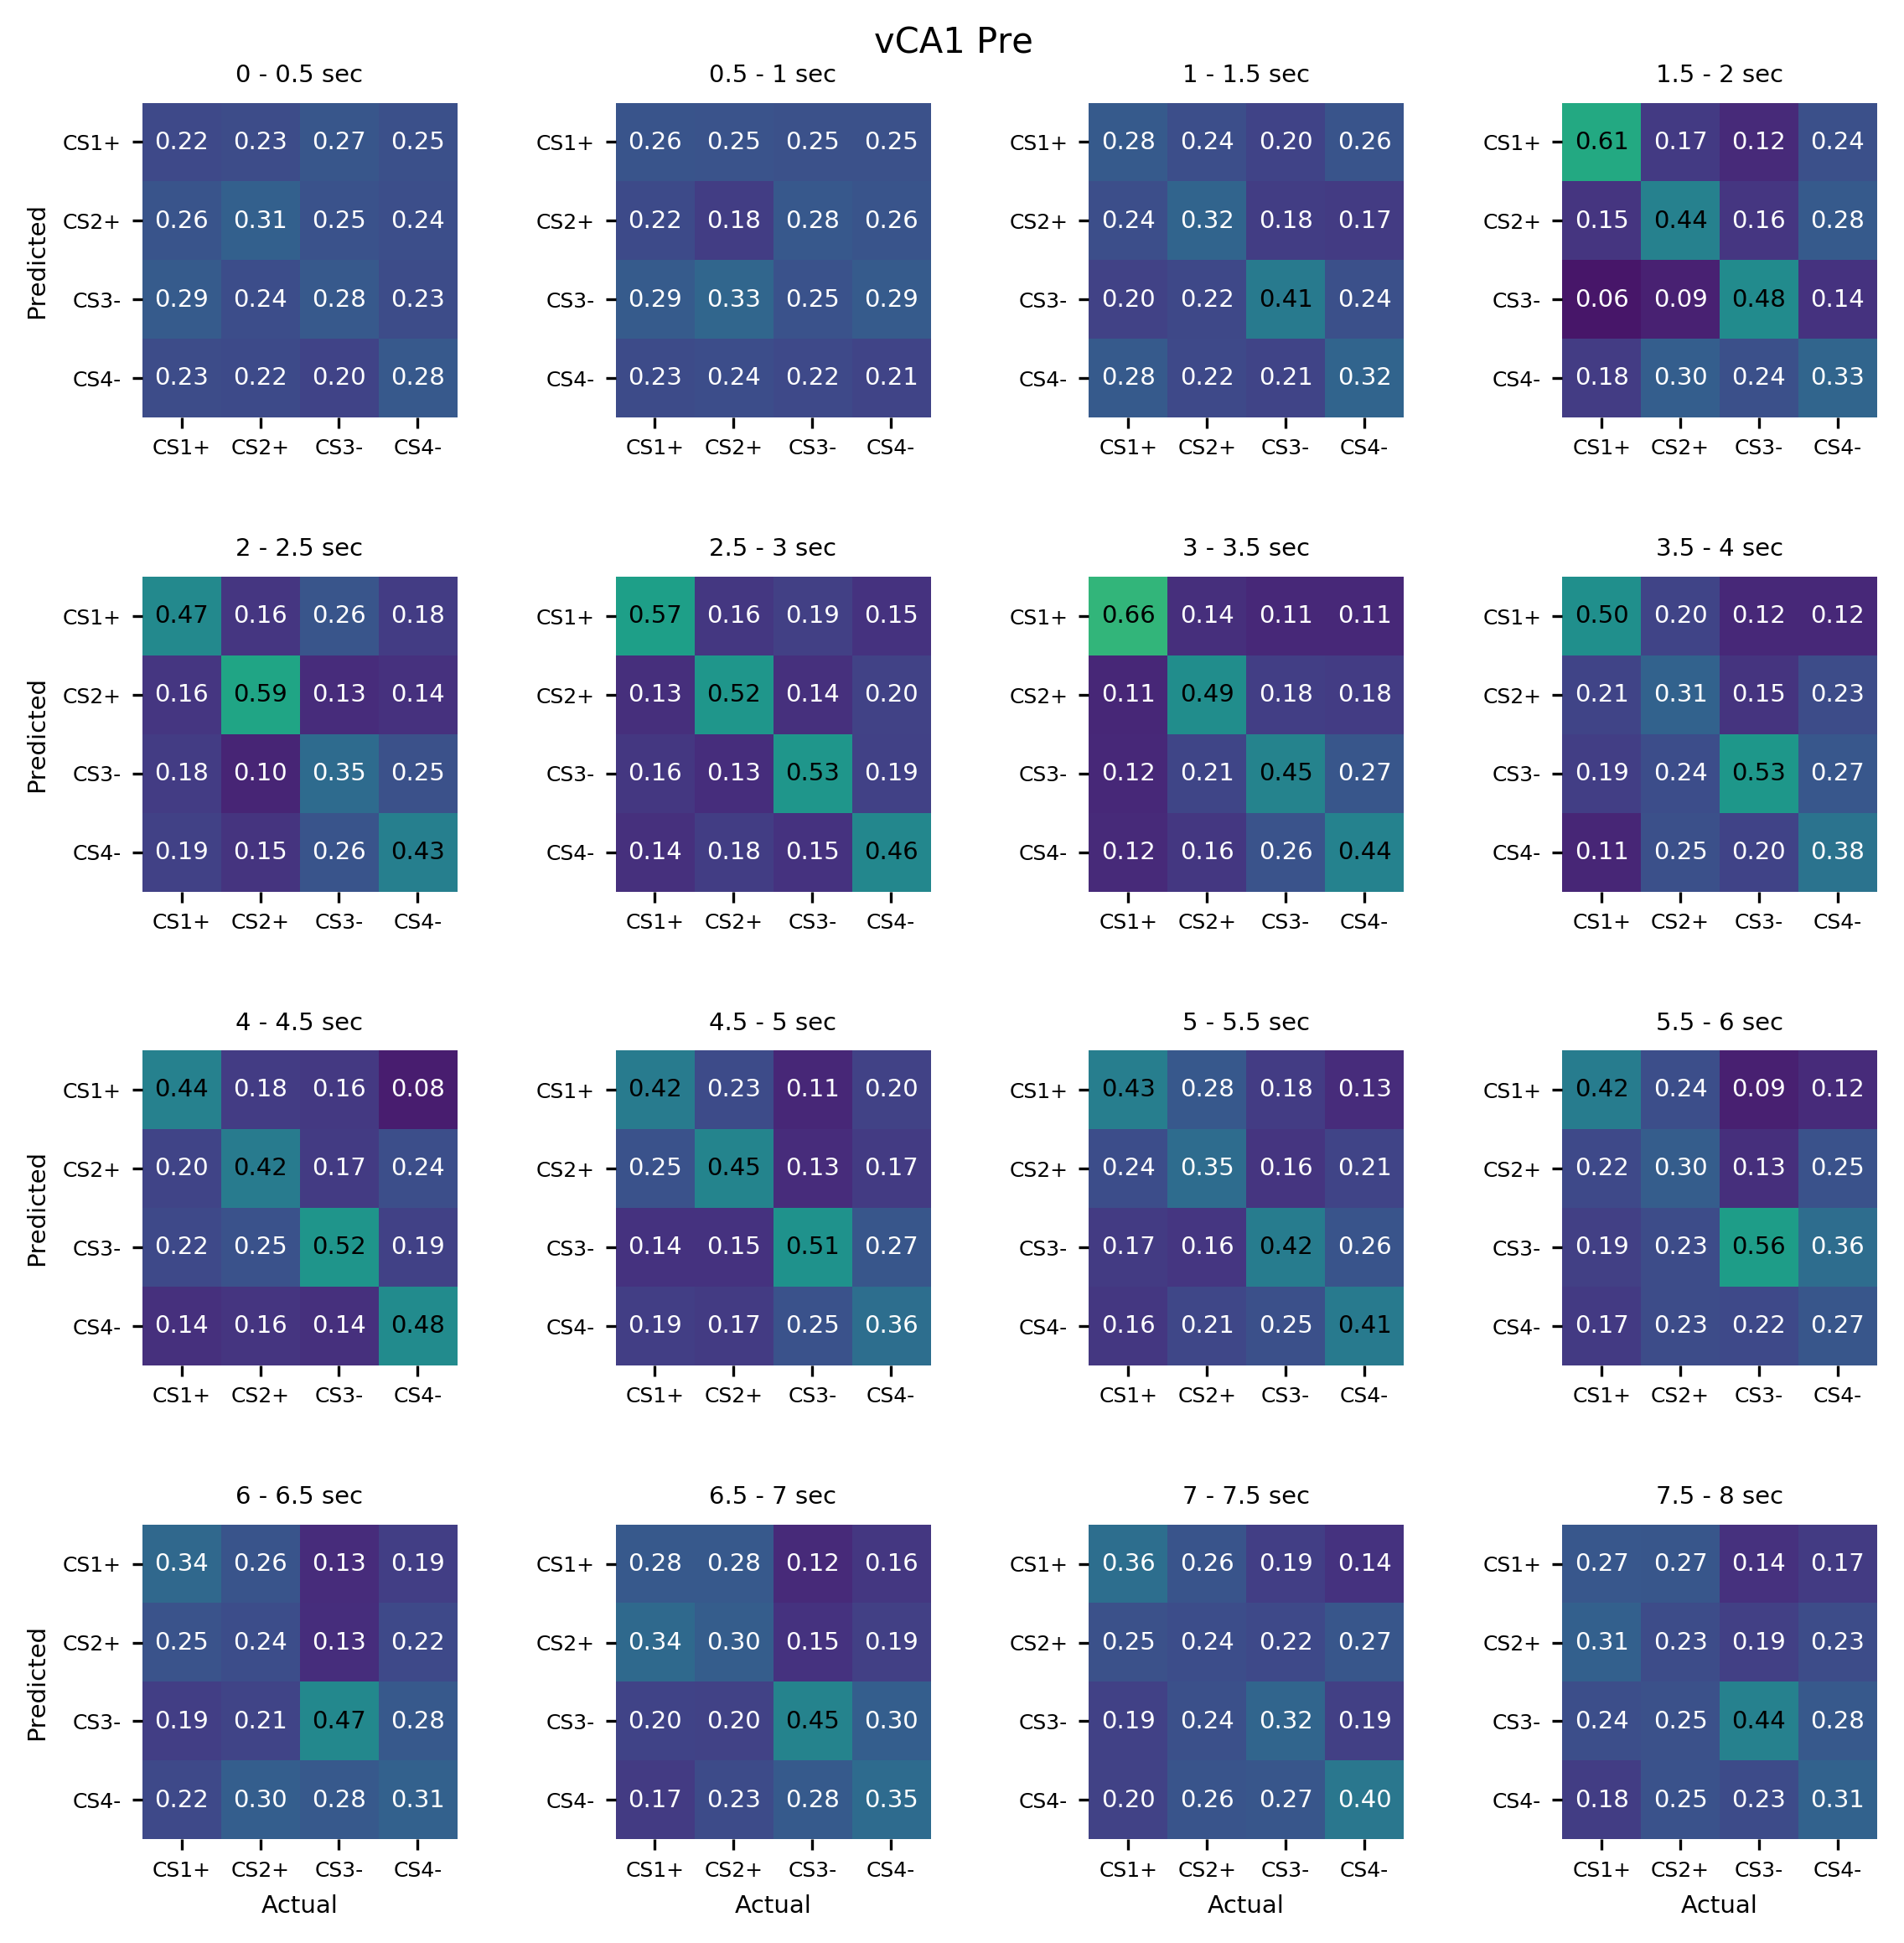

In [108]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3),(ax4, ax5,ax6, ax7),(ax8, ax9,ax10,ax11),(ax12,ax13,ax14,ax15)) = pl.subplots(4, 4, figsize=(8, 8))

for i in range(len(durations)):
    im = heatmap(4.*heatmaps_vhpc_pre[i]/np.sum(heatmaps_vhpc_pre[i]),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", threshold=.4, size=7)
    eval('ax%s'%i).set_title(str(durations[i][0]) +" - "+str(durations[i][1])+" sec")
    for x in range(12,16):
        eval("ax%s"%x).set_xlabel('Actual')
    for y in (0,4,8,12):
        eval("ax%s"%y).set_ylabel('Predicted')

pl.tight_layout(pad=4.5)
pl.suptitle('vCA1 Pre',fontsize=10)
pl.show()
fig.savefig('../img/%s_vhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

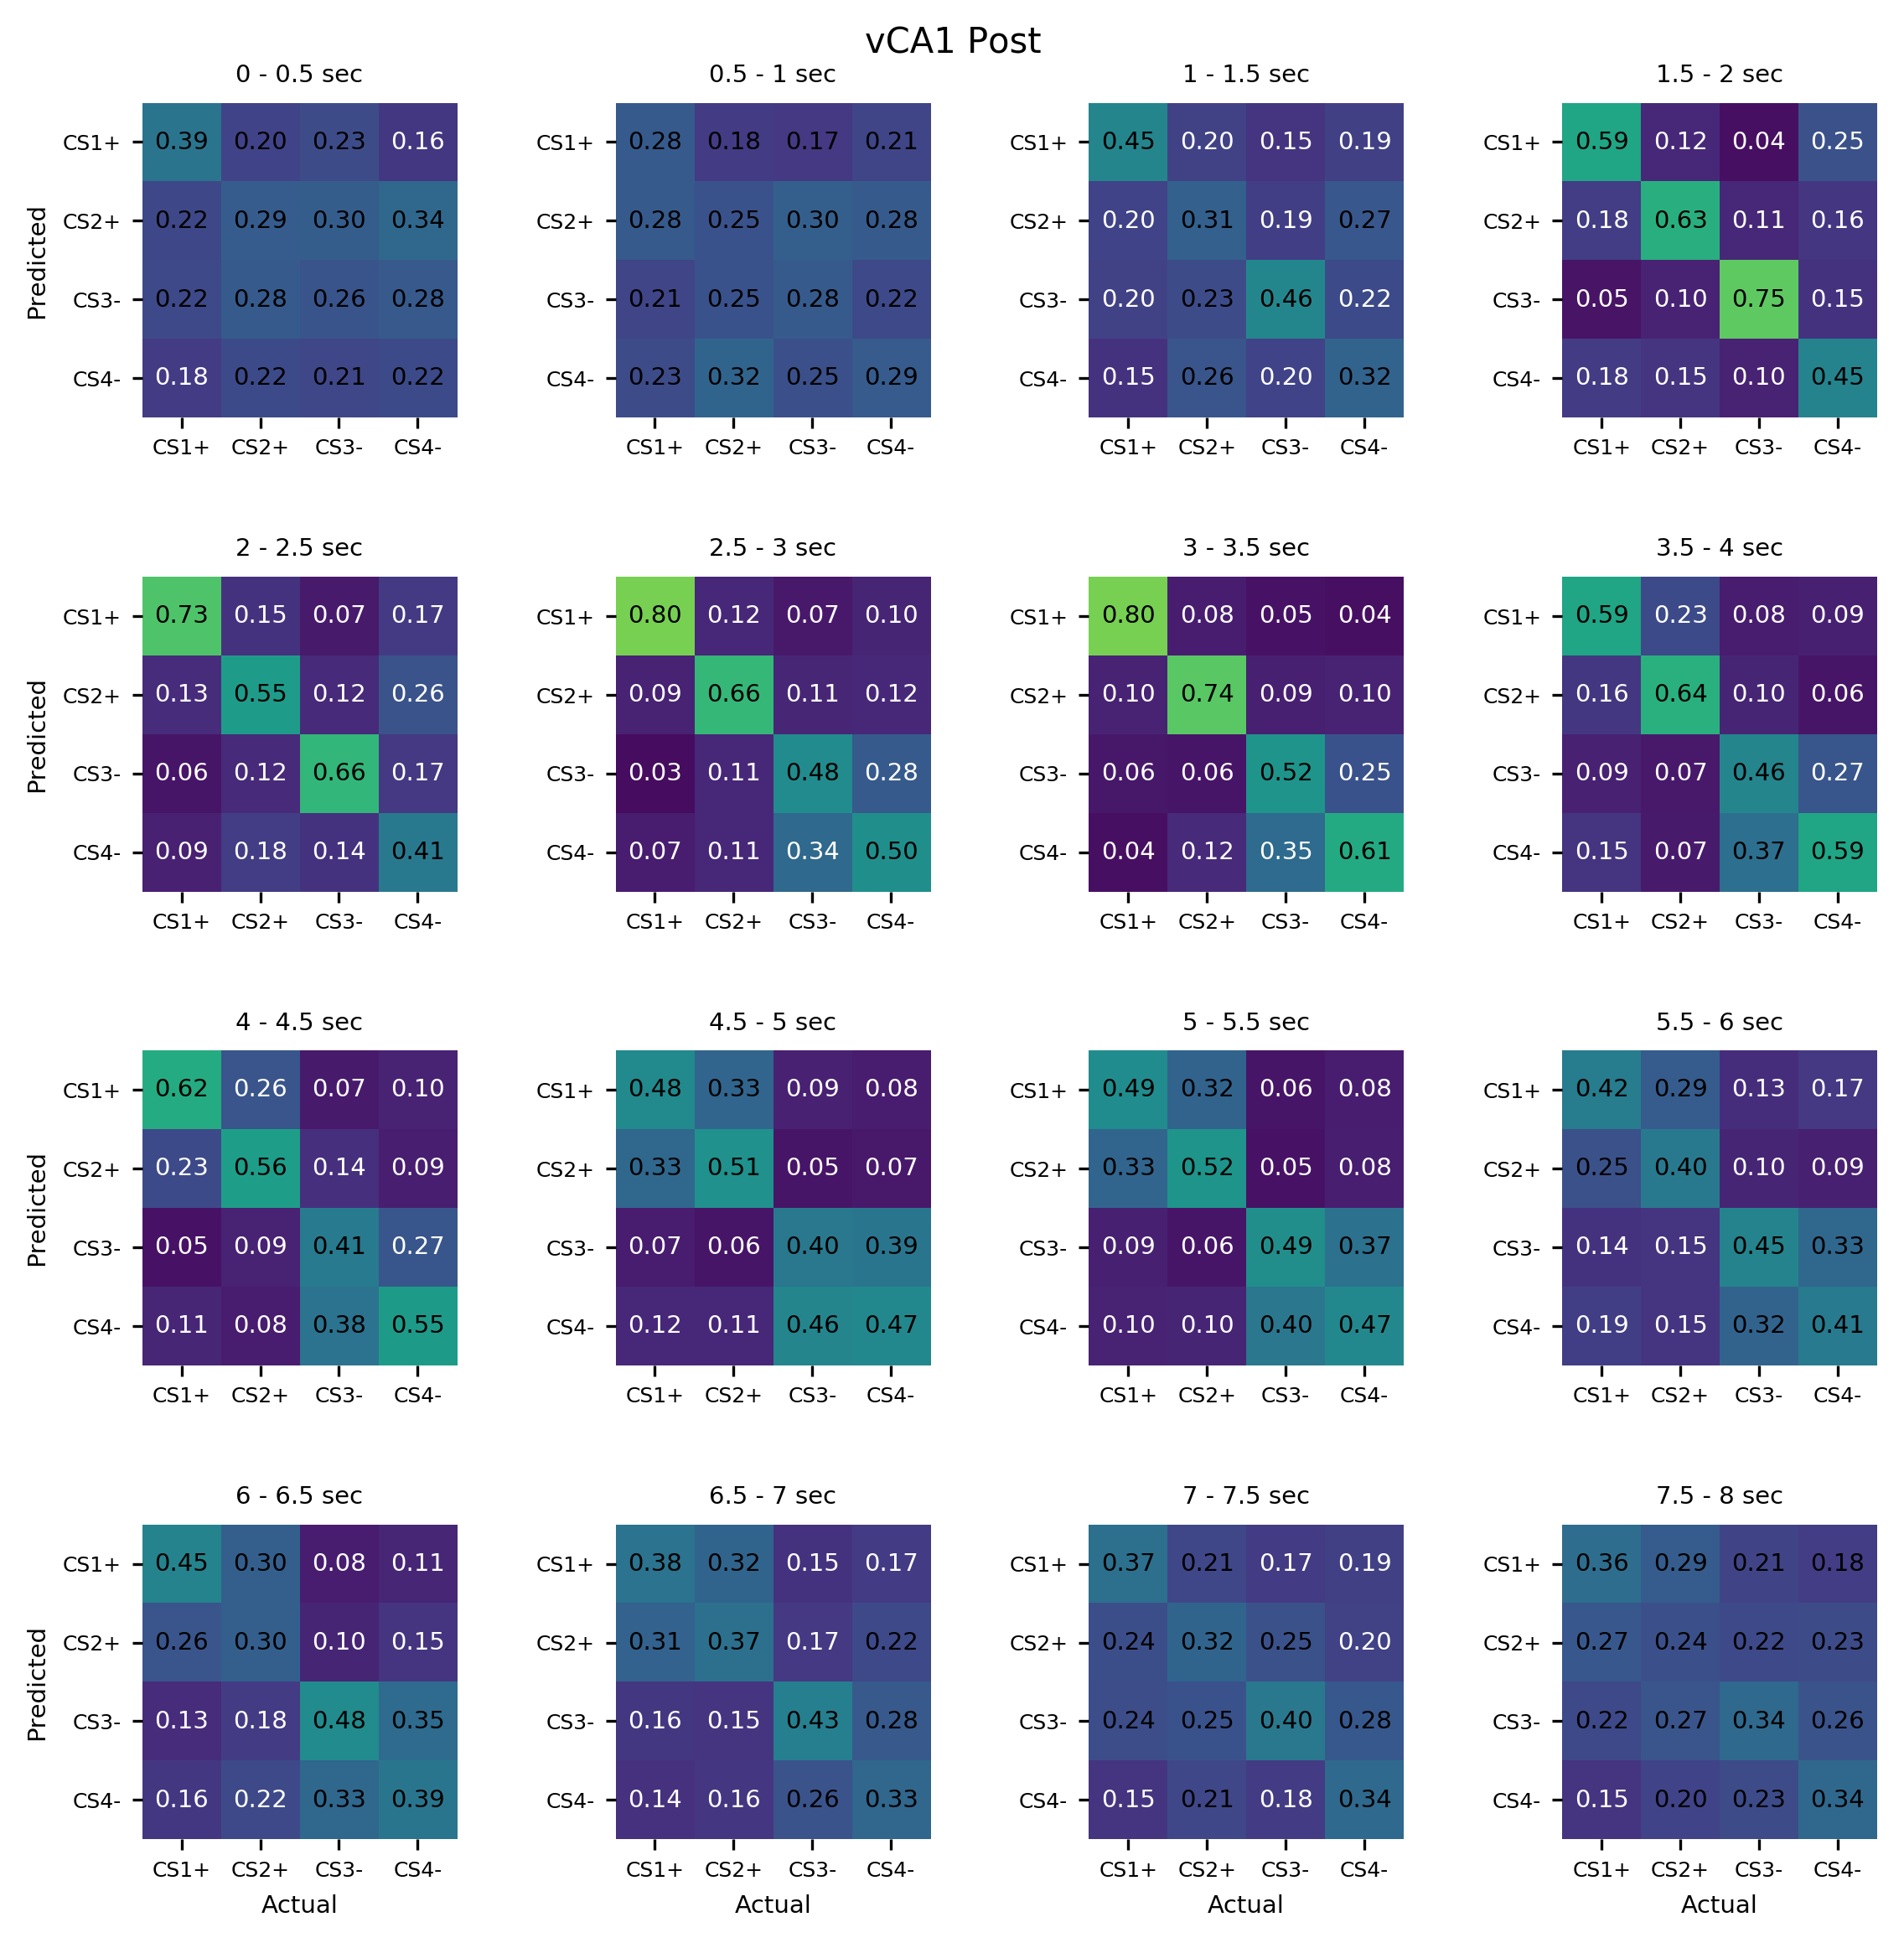

In [109]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3),(ax4, ax5,ax6, ax7),(ax8, ax9,ax10,ax11),(ax12,ax13,ax14,ax15)) = pl.subplots(4, 4, figsize=(8, 8))

for i in range(len(durations)):
    im = heatmap(4.*heatmaps_vhpc_post[i]/np.sum(heatmaps_vhpc_post[i]),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(str(durations[i][0]) +" - "+str(durations[i][1])+" sec")
    for x in range(12,16):
        eval("ax%s"%x).set_xlabel('Actual')
    for y in (0,4,8,12):
        eval("ax%s"%y).set_ylabel('Predicted')

pl.tight_layout(pad=4.5)
pl.suptitle('vCA1 Post',fontsize=10)
pl.show()
fig.savefig('../img/%s_vhpc_post_ALL.jpg'%NOTEBOOK_NAME)

In [ ]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3, ax4, ax5)) = pl.subplots(1, 6, figsize=(10, 3))

for i in range(len(durations)):
    im = heatmap(1.*heatmaps_vhpc_pre[i]/np.sum(heatmaps_vhpc_pre[i], 1),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    #annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(eval('"vHPC, Pre, Duration = %s"'%durations[i]))

pl.tight_layout()
pl.show()
fig.savefig('../img/%s_vhpc_pre_1s.jpg'%NOTEBOOK_NAME)

In [ ]:
fig, ((ax6, ax7, ax8, ax9)) = pl.subplots(1, 4, figsize=(7, 3))

for i in range(len(durations)):
    im = heatmap(1.*heatmaps_vhpc_pre[i]/np.sum(heatmaps_vhpc_pre[i], 1),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    #annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(eval('"vHPC, Pre, Duration = %s"'%durations[i]))

pl.tight_layout()
pl.show()
fig.savefig('../img/%s_vhpc_pre_2s.jpg'%NOTEBOOK_NAME)

In [ ]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3, ax4, ax5)) = pl.subplots(1, 6, figsize=(10, 3))

for i in range(len(durations)):
    im = heatmap(1.*heatmaps_vhpc_post[i]/np.sum(heatmaps_vhpc_post[i], 1),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    #annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(eval('"vHPC, Post, Duration = %s"'%durations[i]))

pl.tight_layout()
pl.show()
fig.savefig('../img/%s_vhpc_post_1s.jpg'%NOTEBOOK_NAME)

In [ ]:
fig, ((ax6, ax7, ax8, ax9)) = pl.subplots(1, 4, figsize=(7, 3))

for i in range(len(durations)):
    im = heatmap(1.*heatmaps_vhpc_post[i]/np.sum(heatmaps_vhpc_post[i], 1),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    #annotate_heatmap(im, valfmt="{x:.2f}", size=7)
    eval('ax%s'%i).set_title(eval('"vHPC, Post, Duration = %s"'%durations[i]))

pl.tight_layout()
pl.show()
fig.savefig('../img/%s_vhpc_post_2s.jpg'%NOTEBOOK_NAME)

In [ ]:
#fig, ax = pl.subplots(1, 1, figsize=(1.5, 1.5))
#
#im = ax.imshow(1.*conf_matr_vhpc_pre_1_2_appended/np.sum(conf_matr_vhpc_pre_1_2_appended, 1), vmin=0, vmax=1)
#
## axs[0].set_xticks(range(len(np.unique(labels))))
## axs[0].set_yticks(range(len(np.unique(labels))))
#
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#ax.set_xticks(range(4))
#ax.set_yticks(range(4))
#ax.set_xticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
#ax.set_yticklabels(['CS1+','CS2+', 'CS3-', 'CS4-'])
#
## axs[0].set_xticklabels(np.arange(len(np.unique(labels)))+1)
## axs[0].set_yticklabels(np.arange(len(np.unique(labels)))+1)
#
#ax.set_title('vHPC Decoding CS, Pre', fontsize=7)
#
#ax.set_xlabel('True Odor', fontsize=5)
#ax.set_ylabel('Predicted Odor', fontsize=5)
#
#cax = fig.add_axes([1.1, 0.2, 0.1, 0.6])
#fig.colorbar(im, cax=cax)
#
## fig.tight_layout()

# and now dhpc

In [38]:
%%time
for dur in durations_print:
    for i in range(loops+1):
        print i,'  ',
        exec("predictions_dhpc_post_%s_%s_%s, test_labels_post_%s_%s_%s, ncells, predictions_dhpc_post_ncells_%s_%s_%s = do_prediction_combined_within(dhpc_post_animals,patterns_evs_dhpc_post_%s_%s, labels_dhpc_post,classes=range(1, 5))"%(dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1]))
        exec("predictions_dhpc_pre_%s_%s_%s,  test_labels_pre_%s_%s_%s,  ncells, predictions_dhpc_pre_ncells_%s_%s_%s  = do_prediction_combined_within(dhpc_pre_animals,patterns_evs_dhpc_pre_%s_%s, labels_dhpc_pre,classes=range(1, 5))"%(dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1],i,dur[0],dur[1]))

0   
1   
2   
3   
4   
5   
6   
7   
8   
9   
10   
11   
12   
13   
14   
15   
16   
17   
18   
19   
20   
21   
22   
23   
24   
25   
26   
27   
28   
29   
30   
31   
32   
33   
34   
35   
36   
37   
38   
39   
40   
41   
42   
43   
44   
45   
46   
47   
48   
49   
50   
0   
1   
2   
3   
4   
5   
6   
7   
8   
9   
10   
11   
12   
13   
14   
15   
16   
17   
18   
19   
20   
21   
22   
23   
24   
25   
26   
27   
28   
29   
30   
31   
32   
33   
34   
35   
36   
37   
38   
39   
40   
41   
42   
43   
44   
45   
46   
47   
48   
49   
50   
0   
1   
2   
3   
4   
5   
6   
7   
8   
9   
10   
11   
12   
13   
14   
15   
16   
17   
18   
19   
20   
21   
22   
23   
24   
25   
26   
27   
28   
29   
30   
31   
32   
33   
34   
35   
36   
37   
38   
39   
40   
41   
42   
43   
44   
45   
46   
47   
48   
49   
50   
0   
1   
2   
3   
4   
5   
6   
7   
8   
9   
10   
11   
12   
13   
14   
15   
16   
17   
18   
19   
20

In [39]:
for dur in durations_print:
    exec('predictions_dhpc_post_%s_%s_appended = np.append(predictions_dhpc_post_%s_%s_1,predictions_dhpc_post_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('test_labels_post_%s_%s_appended = np.append(test_labels_post_%s_%s_1,test_labels_post_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    for i in range (3,loops+1):
        exec("predictions_dhpc_post_%s_%s_appended = np.append(predictions_dhpc_post_%s_%s_appended,predictions_dhpc_post_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))
        exec("test_labels_post_%s_%s_appended = np.append(test_labels_post_%s_%s_appended,test_labels_post_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))

In [40]:
for dur in durations_print:
    exec('predictions_dhpc_pre_%s_%s_appended = np.append(predictions_dhpc_pre_%s_%s_1,predictions_dhpc_pre_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('test_labels_pre_%s_%s_appended = np.append(test_labels_pre_%s_%s_1,test_labels_pre_%s_%s_2)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    for i in range (3,loops+1):
        exec("predictions_dhpc_pre_%s_%s_appended = np.append(predictions_dhpc_pre_%s_%s_appended,predictions_dhpc_pre_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))
        exec("test_labels_pre_%s_%s_appended = np.append(test_labels_pre_%s_%s_appended,test_labels_pre_%s_%s_%s)"%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1],i))

In [41]:
for dur in durations_print:
    exec('conf_matr_dhpc_post_%s_%s_appended = confusion_matrix(predictions_dhpc_post_%s_%s_appended, test_labels_post_%s_%s_appended)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))
    exec('conf_matr_dhpc_pre_%s_%s_appended = confusion_matrix(predictions_dhpc_pre_%s_%s_appended, test_labels_pre_%s_%s_appended)'%(dur[0],dur[1],dur[0],dur[1],dur[0],dur[1]))

In [43]:
heatmaps_dhpc_pre = []
heatmaps_dhpc_post = []
for dur in durations_print:
    exec("heatmaps_dhpc_pre.append(conf_matr_dhpc_pre_%s_%s_appended)"%(dur[0],dur[1]))
    exec("heatmaps_dhpc_post.append(conf_matr_dhpc_post_%s_%s_appended)"%(dur[0],dur[1]))

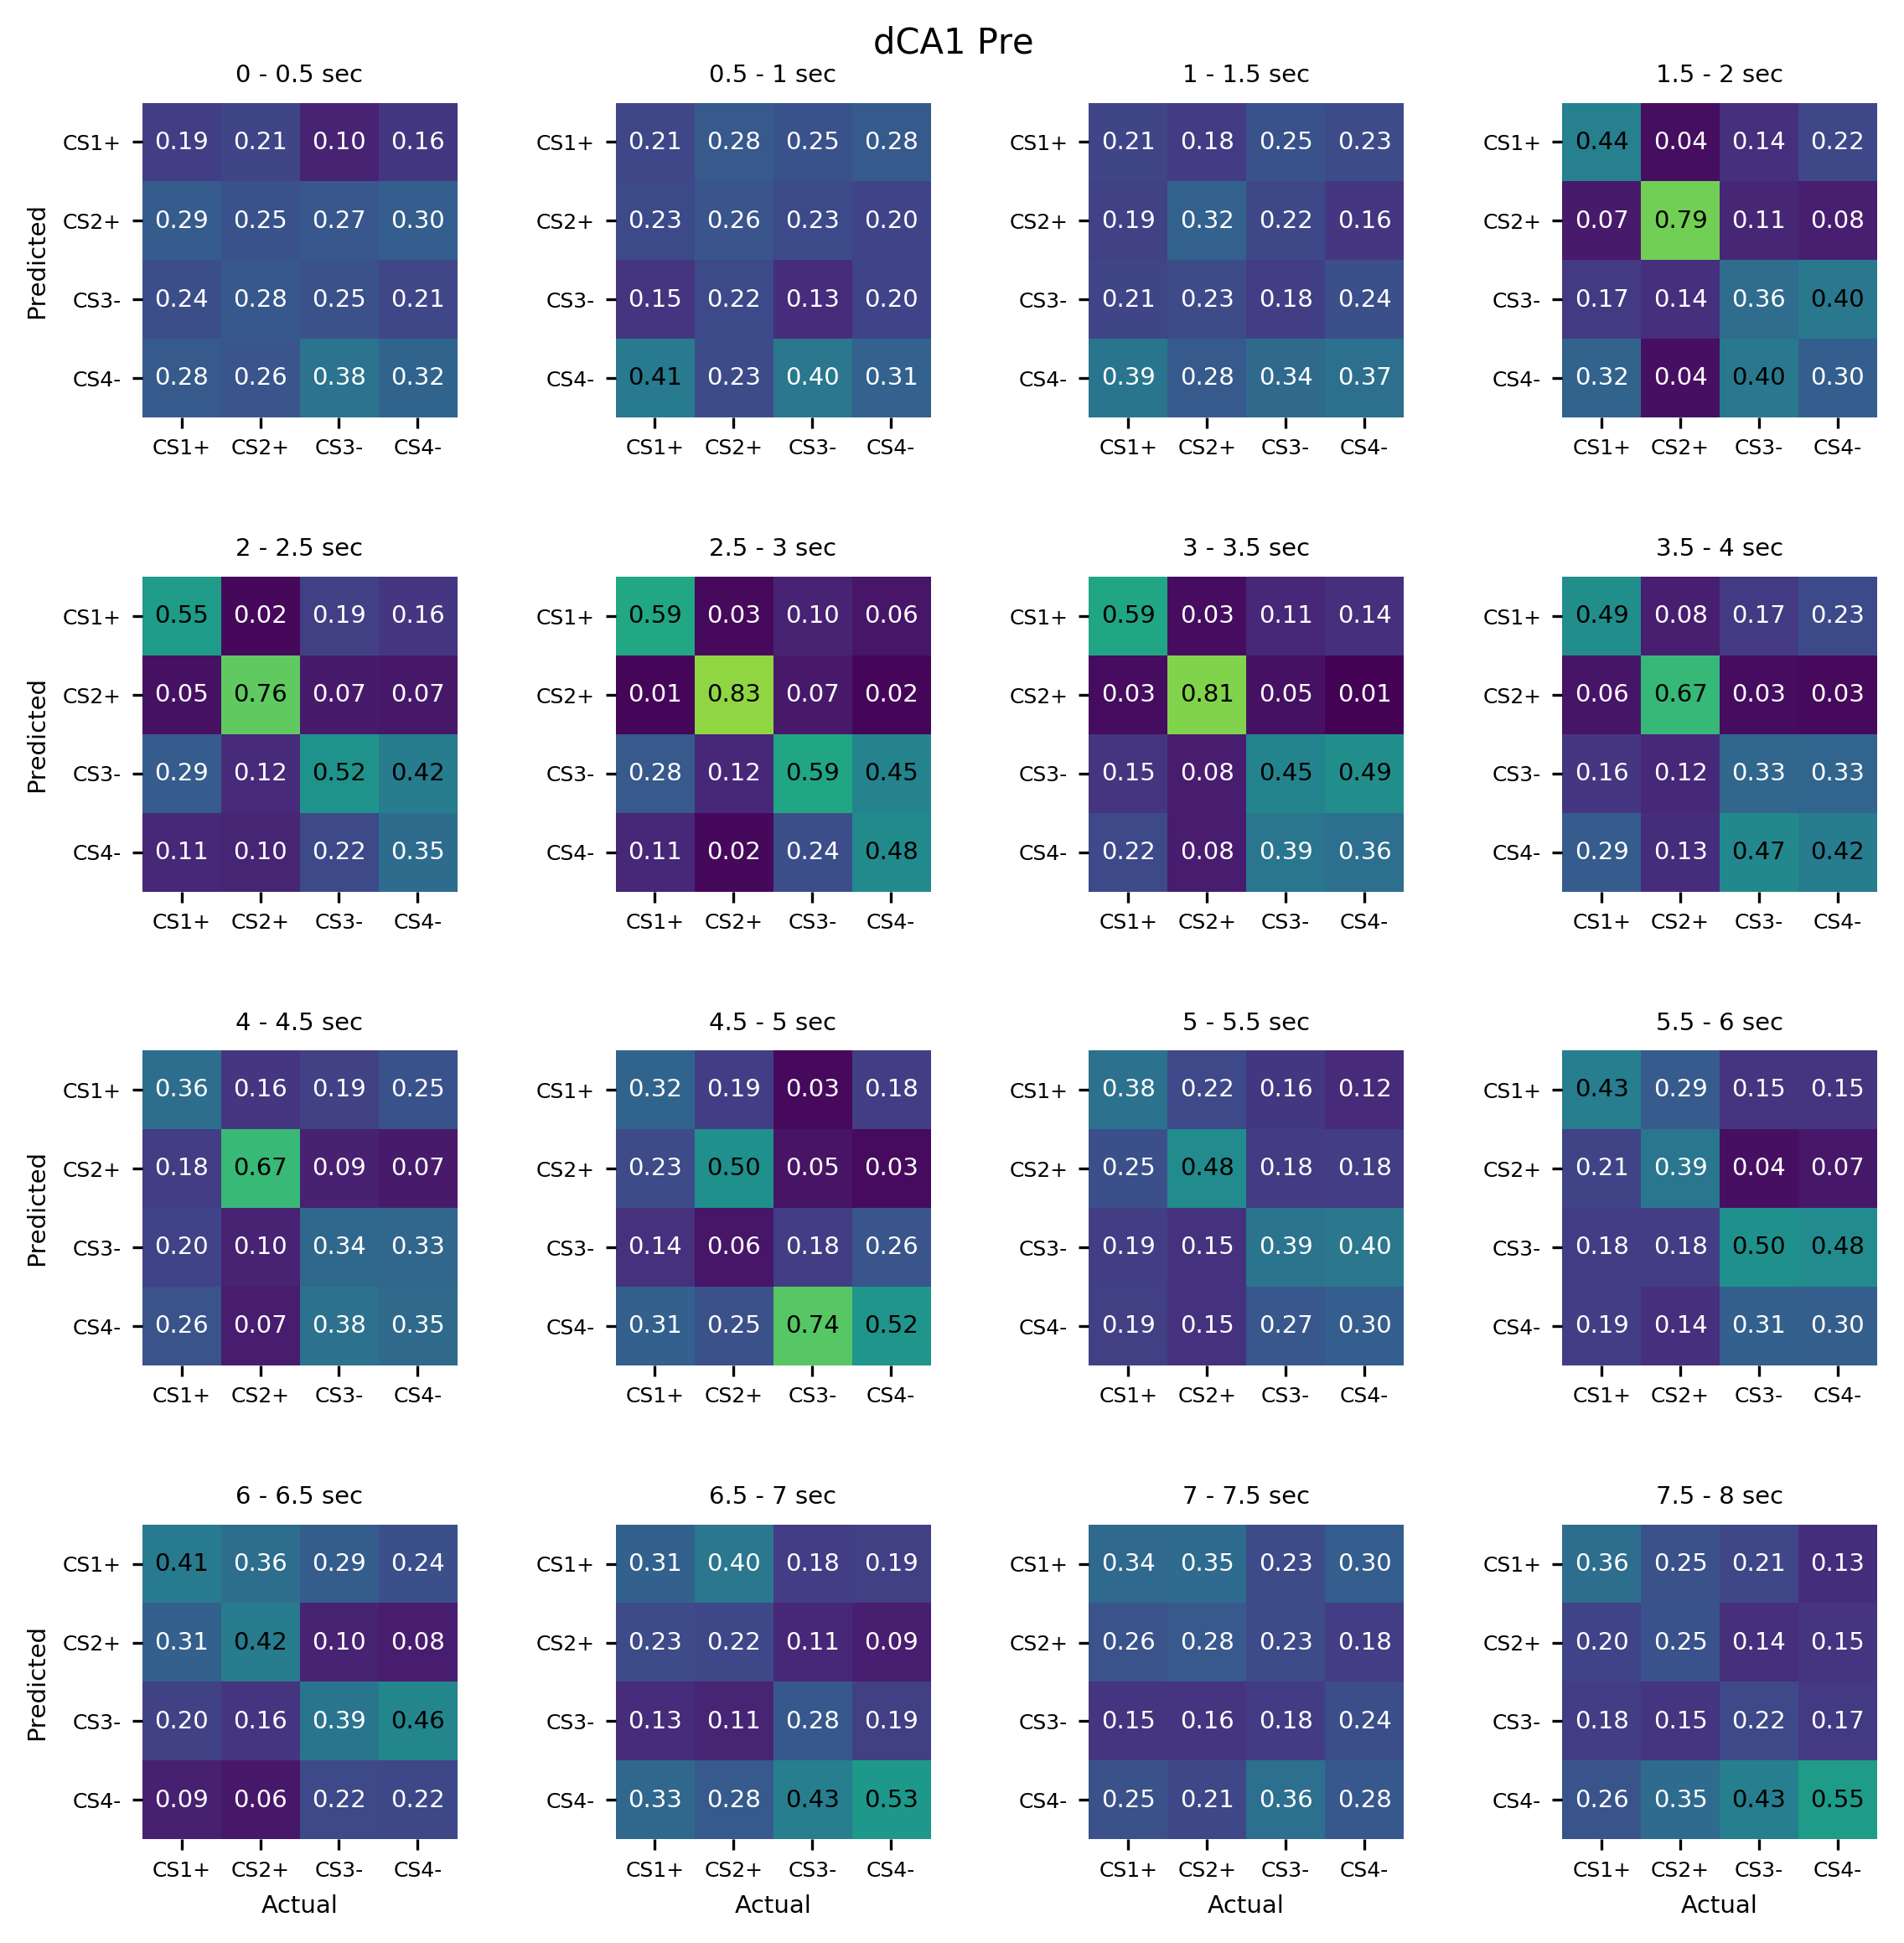

In [107]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3),(ax4, ax5,ax6, ax7),(ax8, ax9,ax10,ax11),(ax12,ax13,ax14,ax15)) = pl.subplots(4, 4, figsize=(8, 8))

for i in range(len(durations)):
    im = heatmap(4.*heatmaps_dhpc_pre[i]/np.sum(heatmaps_dhpc_pre[i]),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", threshold=.4, size=7)
    eval('ax%s'%i).set_title(str(durations[i][0]) +" - "+str(durations[i][1])+" sec")
    for x in range(12,16):
        eval("ax%s"%x).set_xlabel('Actual')
    for y in (0,4,8,12):
        eval("ax%s"%y).set_ylabel('Predicted')

pl.tight_layout(pad=4.5)
pl.suptitle('dCA1 Pre',fontsize=10)
pl.show()
fig.savefig('../img/%s_dhpc_pre_ALL.jpg'%NOTEBOOK_NAME)

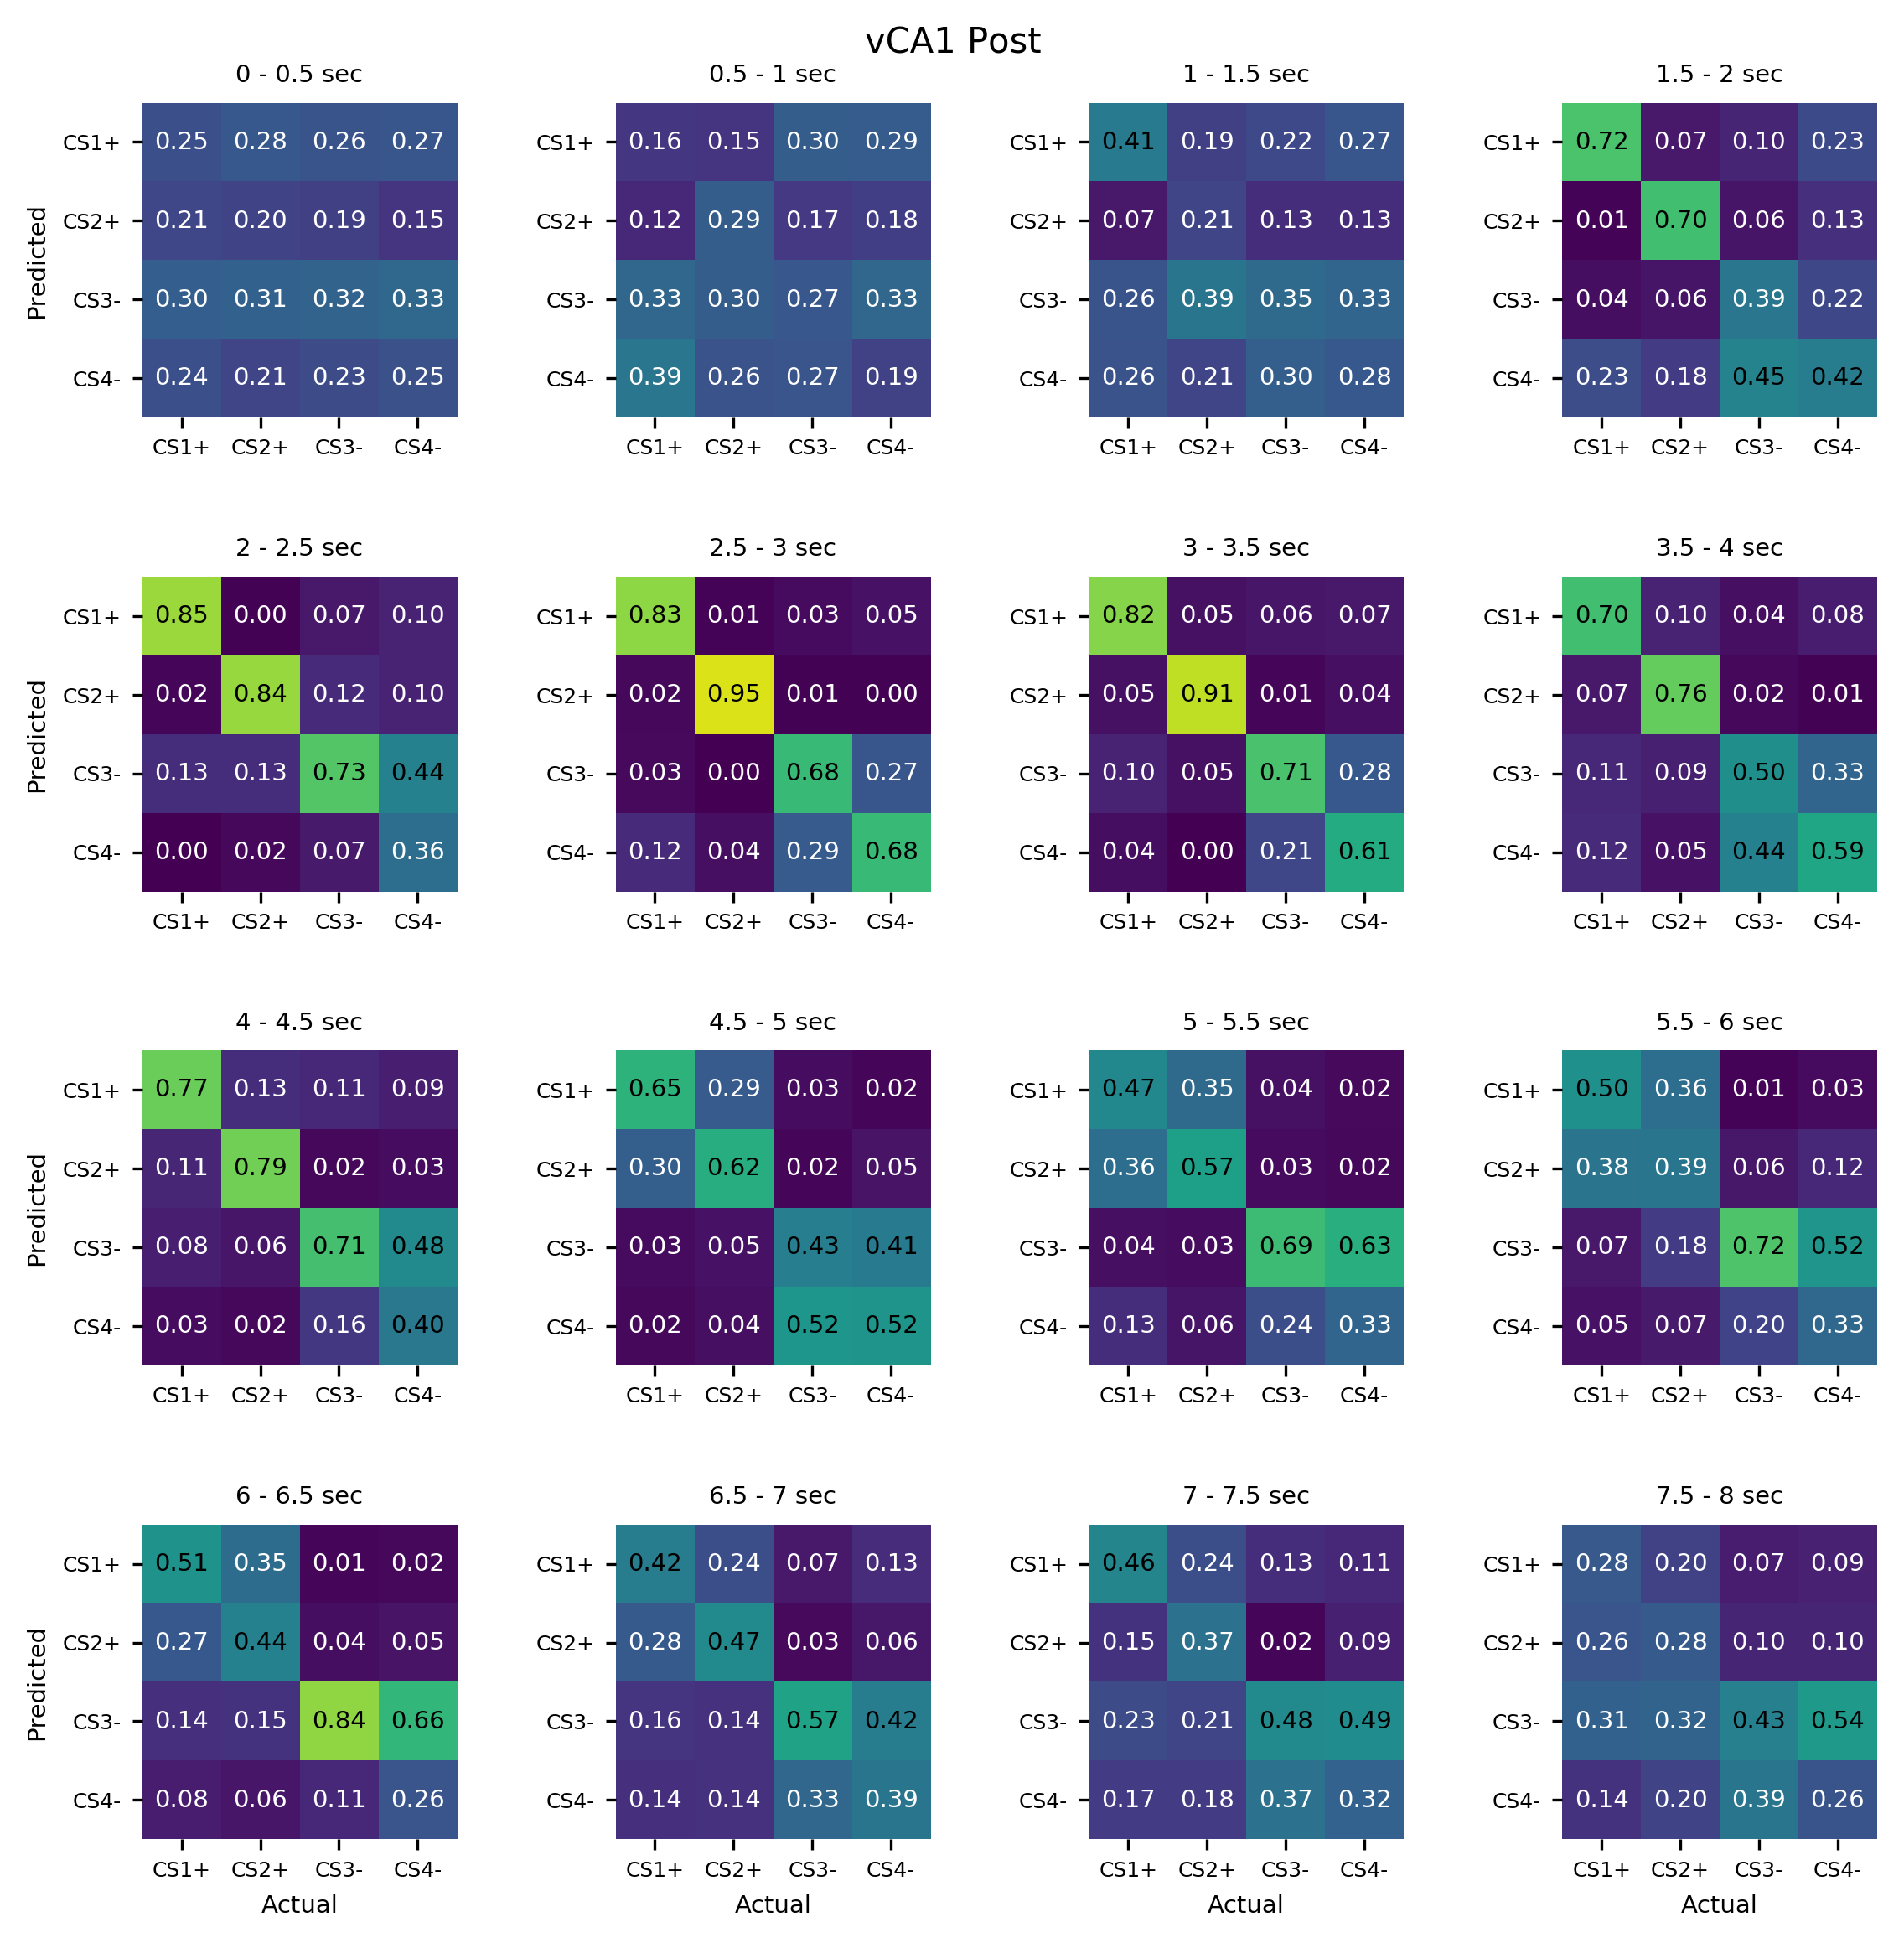

In [106]:
# plot 'em all

fig, ((ax0, ax1, ax2, ax3),(ax4, ax5,ax6, ax7),(ax8, ax9,ax10,ax11),(ax12,ax13,ax14,ax15)) = pl.subplots(4, 4, figsize=(8, 8))

for i in range(len(durations)):
    im = heatmap(4.*heatmaps_dhpc_post[i]/np.sum(heatmaps_dhpc_post[i]),(['CS1+','CS2+', 'CS3-', 'CS4-']),
                 (['CS1+','CS2+', 'CS3-', 'CS4-']), ax=eval('ax%s'%i),vmin=0,vmax=1)
    annotate_heatmap(im, valfmt="{x:.2f}", threshold=.4, size=7)
    eval('ax%s'%i).set_title(str(durations[i][0]) +" - "+str(durations[i][1])+" sec")
    for x in range(12,16):
        eval("ax%s"%x).set_xlabel('Actual')
    for y in (0,4,8,12):
        eval("ax%s"%y).set_ylabel('Predicted')

pl.tight_layout(pad=4.5)
pl.suptitle('vCA1 Post',fontsize=10)
pl.show()
fig.savefig('../img/%s_dhpc_post_ALL.jpg'%NOTEBOOK_NAME)

In [46]:
save_workspace(db)

Could not store variable 'sstats'. Skipping...
Could not store variable 'h5py'. Skipping...
Could not store variable 'ip'. Skipping...
Could not store variable 'sys'. Skipping...
Could not store variable 'ut'. Skipping...
Could not store variable 'glob'. Skipping...
Could not store variable 'np'. Skipping...
Could not store variable 'os'. Skipping...
Could not store variable 'pt'. Skipping...
Could not store variable 'pl'. Skipping...
Could not store variable 'IPython'. Skipping...
Could not store variable 'matplotlib'. Skipping...
Could not store variable 'pickle'. Skipping...
